# Exploring training data near a loss spike

## High-Level overview

This notebook examines data seen in the vicinity of a spike to explore the possibility that spikes are caused by noisy documents. While it's difficult to establish that link with certainty, this exploration did turn up a variety of documents that we'd like to filter out from future versions of pre-training dataset. Some top-level points:

1) There are noisy documents (documents with large fractions of rare or repeated characters that are not NL or structured code) that I think we'd ideally filter out, at something like the the 0.2-0.5% level.

2) They can be found in most sources, but the majority orginate from the stack. They seem to be either columnar/other structured data, or recorded code output.

3) There are some simple filters that we can run that are high recall, but could have beter precision. 

4) It seems with a bit of work, we can come up with a high-quality filter for these documents. 

5) It would be interesting to try restarting the spike run with the noisy examples identified removed from the training sequence and see what happens.

In [81]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import pickle

from olmo.config import TrainConfig
from olmo.data import build_memmap_dataset

In [82]:
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

https://wandb.ai/ai2-llm/olmo-medium/runs/nrqizwgc # original spike

https://wandb.ai/ai2-llm/olmo-medium/runs/l74klryn # finely instrumentad

In [3]:
import wandb
wandb.login()

api = wandb.Api()

wandb: Currently logged in as: dustins (allennlp). Use `wandb login --relogin` to force relogin


### Loading run l74klryn with fine-grained paramater logging

This is a finely instrumented run that crashed spiked aound step 1570

In [4]:
team, project, run_id = "ai2-llm", "olmo-medium", "l74klryn"
run = api.run(f"{team}/{project}/{run_id}")

run.display(height=800)

/usr/lib/python3/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


True

### some notes on this run from Iz:

Looking at the spike at the end of adamw-mitch-init-scale-logit, and trying to find the metric that can early detect it and potentially stop it.

Looking at the loss,

    step 1577: first sign of the spike
    step 1580: it is definitely higher but still not certain it is a spike
    step 1582: it is definitely a spike
    step 1585: spike peak

So we are looking for something that detects it before step 1577

Notice than block.1.*attn_norm saw the spike at step 1565, whole 12 steps before the first sign of the spike in the loss and 20 steps before the spike is clear in the loss.
In other words, the spike becomes imminent many steps before it shows up in the loss

### loading reproduced train order for this run 

The code for generating this training order can be found in this PR:

https://github.com/allenai/LLM/pull/268

In [84]:
train_order = np.memmap("/mnt/tank4/spike_train_order.npy", mode="r", dtype=np.uint64)

In [12]:
# load the memmapped dataset
config = TrainConfig.load("./LLM/configs/v1-mix-medium-mcli.yaml")
dataset = build_memmap_dataset(config, config.data)

In [6]:
global_batch_size = 2048
per_step_train_order = [train_order[t : t + global_batch_size] for t in range(0, len(train_order), global_batch_size)]

### load some batches from long prespike baseline for comparison

In [7]:
with open('/mnt/tank3/training_investigation/baseline_batches_500_620.pkl', 'rb') as f:
    batches_baseline = pickle.load(f)

### load data before and around the spike

In [13]:
def get_data_for_step(batch):
    batch_contexts = [dataset[int(i)] for i in batch]
    return batch_contexts


def get_range_of_steps(batches):
    data_per_step = [get_data_for_step(b) for b in tqdm(batches)]
    return data_per_step

In [9]:
# %%time 
# spike_range = per_step_train_order[1550:1580]
# spike_batches = get_range_of_steps(spike_range)

In [893]:
# %%time 
# long_before_spike = get_range_of_steps(per_step_train_order[1000:1005])

In [15]:
# with open('/mnt/tank3/training_investigation/spike_batches_fi_1000_1005.pkl', 'rb') as f:
#     long_before_spike = pickle.load(f)

    
# with open('/mnt/tank3/training_investigation/spike_batches_fi_1550_1580.pkl', 'rb') as f:
#     spike_batches = pickle.load(f)

    
# with open('/mnt/tank3/training_investigation/spike_batches_fi_1000_1005.pkl', 'rb') as f:
#     long_before_spike = pickle.load(f)

In [85]:
from collections import Counter
from olmo.tokenizer import Tokenizer
from copy import deepcopy


cfg = TrainConfig.load("LLM/configs/v1-mix-medium-mcli.yaml")
tokenizer = Tokenizer.from_train_config(cfg)


def collect_sources_in_batch(batch):
    sources = []
    for c in batch:
        source = c['metadata']['path'].split('/')[7] 
        sources.append(source)
    return sources


def comp_batch_source_fractions(batches):
    sources = [collect_sources_in_batch(b) for b in batches]
    sources_flat = [s for b in sources for s in b]
    source_counts = pd.Series(sources_flat).value_counts()
    source_counts_fracts = source_counts / source_counts.sum()
    return pd.DataFrame(source_counts_fracts).round(3) * 100


def count_tokens_per_batch(batch):
    running_batch_counts = Counter()
    for c in batch:
        tokens = c['input_ids']
        counts = Counter(tokens.tolist())
        running_batch_counts.update(counts)
    return running_batch_counts


def count_tokens_in_batches(batches):
    running_counts = Counter()
    for batch in batches:
        batch_counts = count_tokens_per_batch(batch)
        running_counts.update(batch_counts)
    token_count_df = pd.DataFrame(pd.Series(running_counts).sort_values(ascending=False))
    token_count_df.columns = ['count']
    token_count_df['token_encoded'] = token_count_df.index
    token_count_df['token'] = token_count_df['token_encoded'].apply(lambda x: tokenizer.decode([x]))
    token_count_df['fraction'] = token_count_df['count'] / token_count_df['count'].sum()
    token_count_df = token_count_df.reset_index()
    return token_count_df[['token', 'fraction', 'token_encoded', 'count']]


def find_contexts_with_token(batches, token_id, min_occurrence=0):
    containing_contexts = []
    for i, b in enumerate(batches):
        for c in b:
            if token_id in c['input_ids']:
                tokens, counts = np.unique(c['input_ids'].numpy(), return_counts=True)
                token_counts = dict(zip(tokens, counts))
                count_of_target_token = token_counts[token_id]
                if count_of_target_token > min_occurrence:
                    containing_contexts.append((c, count_of_target_token,))
    containing_contexts = sorted(containing_contexts, key=lambda x: x[1], reverse=True)
    return containing_contexts


def build_token_fract_comp_df(baseline_token_counts, examine_batches_token_counts, min_token_occurrence=None, min_relative_fraction=None, sort_on='count_y'):
    combined_token_count_df = pd.merge(baseline_token_counts, examine_batches_token_counts, left_on='token_encoded', right_on='token_encoded', how='outer')
    combined_token_count_df_in_both = deepcopy(combined_token_count_df.dropna())
    in_examine_but_not_baseline = deepcopy(combined_token_count_df[combined_token_count_df['token_x'].isna()])
    in_examine_but_not_baseline['relative_fract'] = 10000 # set an arbitrary high fraction so these stick out 
    combined_token_count_df_in_both['relative_fract'] = combined_token_count_df_in_both['fraction_y'] / combined_token_count_df_in_both['fraction_x']    
    combined_token_count_df_combined = pd.concat([combined_token_count_df_in_both, in_examine_but_not_baseline])
    threshed_df = deepcopy(combined_token_count_df_combined)
    if min_token_occurrence:
        threshed_df = threshed_df[threshed_df['count_y'] > min_token_occurrence]
    if min_relative_fraction:
            threshed_df = threshed_df[threshed_df['relative_fract'] > min_relative_fraction]
    sorted_enriched_tokens = threshed_df.sort_values(sort_on, ascending=False)
    return sorted_enriched_tokens[['token_encoded', 'token_y', 'count_y', 'relative_fract']]


def find_contexts_containing_token(search_batches, search_token, min_occurrence=10):
    decoded_token = tokenizer.decode([search_token])
    containing_contexts = find_contexts_with_token(search_batches, search_token, min_occurrence)
    print(f'found {len(containing_contexts)} documents with ' + ', '.join([str(i[1]) for i in containing_contexts]) + f' occurrences of token {decoded_token}')
    return containing_contexts


def print_single_context(context, decoded_token=None):
    print_out = f"source {'/'.join(context[0]['metadata']['path'].split('/')[-2:])}"
    if decoded_token: 
        print_out += f"contains {context[1]} instances of token: {decoded_token}\n"
    print(print_out)
    detokenized = tokenizer.decode(context[0]['input_ids'].tolist())
    print(detokenized)
    return detokenized

### computing token fractions relative to a long, stable baseline

In [16]:
# this is a long, 100 step baseline from steps 500-600 
baseline_token_counts = count_tokens_in_batches(batches_baseline)

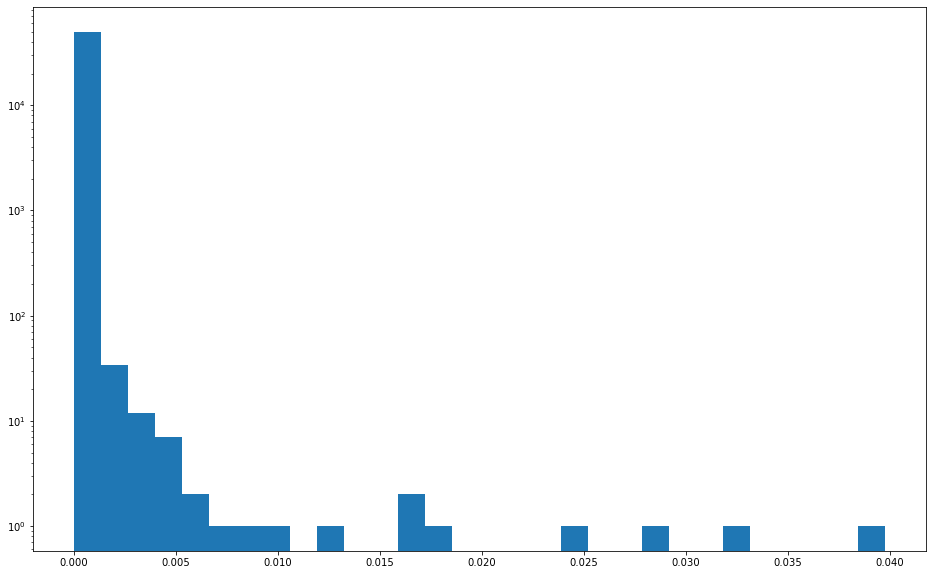

In [92]:
_= baseline_token_counts.fraction.hist(log=True, bins=30)

<AxesSubplot:>

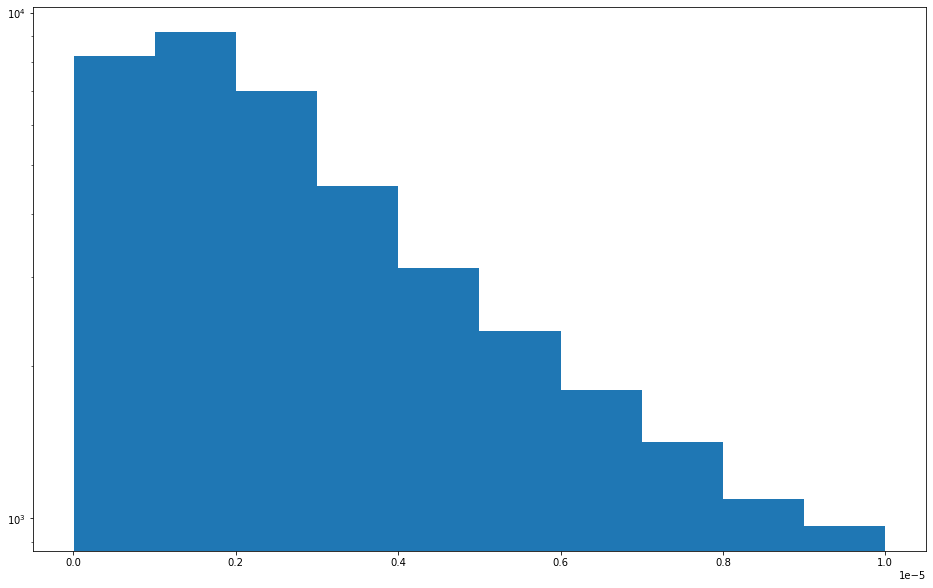

In [125]:
baseline_token_counts[baseline_token_counts.fraction < 10 ** -5].fraction.hist(log=True)

### computing token counts and fractions for several ranges of interest

The general idea here is to count the occurrence of tokens in batches and compare the fractional makeup of batches near the spike to a long, quiet baseline. Tokens that are rare in general but make up large fractions of particular contexts raise suspicion.

In [17]:
# this is long before the spike, steps 1000-1005
spike_token_counts_long_before = count_tokens_in_batches(long_before_spike)

In [18]:
# this is still well before the spike
start_step, stop_step = 1550, 1555
start_step, stop_step = start_step - 1550, stop_step -1550

pre_spike_batches = spike_batches [start_step : stop_step]
spike_token_counts_pre = count_tokens_in_batches(pre_spike_batches)

In [19]:
# a range leading into the earliest signs of the spike 
start_step, stop_step= 1560, 1565
start_step, stop_step  = start_step - 1550, stop_step -1550

early_spike_batches = spike_batches[start_step : stop_step]
spike_token_counts_early = count_tokens_in_batches(early_spike_batches)

In [20]:
# a range getting well into the spike 

start_step, stop_step = 1575, 1580
start_step, stop_step = start_step - 1550, stop_step -1550

late_spike_batches = spike_batches[start_step : stop_step]
spike_token_counts_late = count_tokens_in_batches(late_spike_batches)

In [22]:
# this is the batch proceeding the first detectable sign of ths spike in block.1.*attn_norm 
start_step, stop_step = 1564, 1565
start_step, stop_step = start_step - 1550, stop_step -1550

particular_spike_batch = spike_batches[start_step : stop_step]
spike_token_counts_particular_batch = count_tokens_in_batches(particular_spike_batch)

In [86]:
min_relative_fraction = 5
min_token_occurrence = 10
sort_on = 'count_y'

comp_long_before_df = build_token_fract_comp_df(baseline_token_counts, spike_token_counts_long_before, min_relative_fraction= min_relative_fraction, min_token_occurrence=min_token_occurrence, sort_on=sort_on)
comp_pre_df = build_token_fract_comp_df(baseline_token_counts, spike_token_counts_pre, min_relative_fraction= min_relative_fraction, min_token_occurrence=min_token_occurrence, sort_on=sort_on)
comp_early_df = build_token_fract_comp_df(baseline_token_counts, spike_token_counts_early, min_relative_fraction=min_relative_fraction, min_token_occurrence=min_token_occurrence, sort_on=sort_on)
comp_late_df = build_token_fract_comp_df(baseline_token_counts, spike_token_counts_late, min_relative_fraction=min_relative_fraction, min_token_occurrence=min_token_occurrence, sort_on=sort_on)

comp_particular_batches_df = build_token_fract_comp_df(baseline_token_counts, spike_token_counts_particular_batch, min_relative_fraction= min_relative_fraction, min_token_occurrence=min_token_occurrence, sort_on=sort_on)

**These dataframes quickly surface unusual tokens that are enriched in the regions being examined relative the baseline.**

In [103]:
comp_pre_df.head(10)

,token_encoded,token_y,count_y,relative_fract
31960,49475,988,249.0,5.757225
35381,11824,)_,233.0,6.641330
41346,43348,Cand,157.0,7.246154
44099,38689,%%,156.0,10.314050
40342,26241,hdr,142.0,5.947644
46041,39891,hline,95.0,9.268293
43622,13377,Ø,93.0,5.737789
44180,43184,CRYPT,82.0,5.497207
43955,25372,Nob,81.0,5.239892
44236,27759,caso,81.0,5.476056


Here we see the token "988" appears 249 times in the spike_token_counts_pre range of batches.

We can now go and look for contexts containing this token..

In [108]:
token_row_number = 0 # this is the row in the comparison df to search for, 0 -> highest count token
search_token = comp_pre_df.iloc[token_row_number]['token_encoded']
offending_contexts = find_contexts_containing_token(pre_spike_batches, search_token) # make sure to change the search batches to match the comparon df source

found 2 documents with 183, 19 occurrences of token 988


**The document with 183 occurrences looks suspicious, so let's take a look at that:**

In [109]:
print_single_context(offending_contexts[0], decoded_token)

source stack/069_00002.npycontains 183 instances of token: "|

1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
1040.
993.948
948.17
902.655
857.389
812.361
767.561
722.977
678.601
634.424
590.437
546.631
503.
459.536
843.243
832.
821.053
810.39
800.
789.873
780.
770.37
760.976
751.807
742.857
734.118
725.581
717.241
709.091
701.124
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
693.333
69

'1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n1040.\n993.948\n948.17\n902.655\n857.389\n812.361\n767.561\n722.977\n678.601\n634.424\n590.437\n546.631\n503.\n459.536\n843.243\n832.\n821.053\n810.39\n800.\n789.873\n780.\n770.37\n760.976\n751.807\n742.857\n734.118\n725.581\n717.241\n709.091\n701.124\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n693.333\n69

Ouch, that doesn't look good.

Now let's take a look at the single batch just before the first sign of the spike

In [110]:
comp_particular_batches_df.head(10)

,token_encoded,token_y,count_y,relative_fract
4366,5246,xy,550.0,5.012531
8841,11946,127,310.0,6.273187
32425,38978,861,301.0,35.727003
22184,47499,':',261.0,16.865913
9546,1337,",\",231.0,5.115335
27564,31899,"""|",186.0,16.656716
12004,8971,2001,173.0,5.027852
16152,23558,298,142.0,5.960126
16998,32157,Added,139.0,6.240180
28864,43316,改,138.0,13.365617


**The token xy appears 555 times, which is quite high for a rare token like this, taking a look at the contexts containing it:**

In [105]:
token_row_number = 0
search_token = comp_particular_batches_df.iloc[token_row_number]['token_encoded']
offending_contexts = find_contexts_containing_token(particular_spike_batch, search_token)

found 3 documents with 170, 167, 165 occurrences of token xy


**It's unusual to find 3 docs in the same batch with such a high count of the same rare token.**

Taking a look at all three:

In [107]:
print_single_context(offending_contexts[0], decoded_token)

source stack/187_00001.npycontains 170 instances of token: "|

.506146) (xy 308.753539 171.674067) (xy 308.818897 171.889523)
        (xy 308.925033 172.088089) (xy 308.981916 172.157401) (xy 309.02975 172.215686) (xy 309.067868 172.262133) (xy 309.111478 172.297923)
        (xy 311.277001 174.463447) (xy 311.277 177.326554) (xy 309.64023 178.963324) (xy 309.47251 178.996686) (xy 309.218273 179.101995)
        (xy 308.989465 179.25488) (xy 308.79488 179.449465) (xy 308.641995 179.678273) (xy 308.536686 179.93251) (xy 308.483 180.202408)
        (xy 308.483 180.477592) (xy 308.536686 180.74749) (xy 308.641995 181.001727) (xy 308.737 181.143912) (xy 308.737001 184.616087)
        (xy 308.641995 184.758273) (xy 308.536686 185.01251) (xy 308.483 185.282408) (xy 308.483 185.557592) (xy 308.536686 185.82749)
        (xy 308.641995 186.081727) (xy 308.79488 186.310535) (xy 308.989465 186.50512) (xy 309.218273 186.658005) (xy 309.47251 186.763314)
        (xy 309.742408 186.817) (xy 310.017592

'.506146) (xy 308.753539 171.674067) (xy 308.818897 171.889523)\n        (xy 308.925033 172.088089) (xy 308.981916 172.157401) (xy 309.02975 172.215686) (xy 309.067868 172.262133) (xy 309.111478 172.297923)\n        (xy 311.277001 174.463447) (xy 311.277 177.326554) (xy 309.64023 178.963324) (xy 309.47251 178.996686) (xy 309.218273 179.101995)\n        (xy 308.989465 179.25488) (xy 308.79488 179.449465) (xy 308.641995 179.678273) (xy 308.536686 179.93251) (xy 308.483 180.202408)\n        (xy 308.483 180.477592) (xy 308.536686 180.74749) (xy 308.641995 181.001727) (xy 308.737 181.143912) (xy 308.737001 184.616087)\n        (xy 308.641995 184.758273) (xy 308.536686 185.01251) (xy 308.483 185.282408) (xy 308.483 185.557592) (xy 308.536686 185.82749)\n        (xy 308.641995 186.081727) (xy 308.79488 186.310535) (xy 308.989465 186.50512) (xy 309.218273 186.658005) (xy 309.47251 186.763314)\n        (xy 309.742408 186.817) (xy 310.017592 186.817) (xy 310.28749 186.763314) (xy 310.541727 186.

In [62]:
print_single_context(offending_contexts[1], decoded_token)

source stack/187_00000.npycontains 167 instances of token: "|

19 131.275565) (xy 140.680308 131.563827) (xy 140.547636 131.884127) (xy 140.48 132.224155)
        (xy 140.48 132.570845) (xy 140.547636 132.910873) (xy 140.680308 133.231173) (xy 140.812638 133.429219) (xy 140.529549 133.485529)
        (xy 140.254747 133.599356) (xy 140.007431 133.764607) (xy 139.797107 133.974931) (xy 139.631856 134.222247) (xy 139.518029 134.497049)
        (xy 139.46 134.788778) (xy 133.182994 134.788778) (xy 133.078256 134.718795) (xy 132.889898 134.640774) (xy 132.832619 134.629381)
        (xy 132.821226 134.572102) (xy 132.743205 134.383744) (xy 132.629937 134.214226) (xy 132.485774 134.070063) (xy 132.316256 133.956795)
        (xy 132.127898 133.878774) (xy 132.096922 133.872612) (xy 132.059226 133.683102) (xy 131.981205 133.494744) (xy 131.867937 133.325226)
        (xy 131.723774 133.181063) (xy 131.554256 133.067795) (xy 131.365898 132.989774) (xy 131.308619 132.978381) (xy 131.297226 132.921

'19 131.275565) (xy 140.680308 131.563827) (xy 140.547636 131.884127) (xy 140.48 132.224155)\n        (xy 140.48 132.570845) (xy 140.547636 132.910873) (xy 140.680308 133.231173) (xy 140.812638 133.429219) (xy 140.529549 133.485529)\n        (xy 140.254747 133.599356) (xy 140.007431 133.764607) (xy 139.797107 133.974931) (xy 139.631856 134.222247) (xy 139.518029 134.497049)\n        (xy 139.46 134.788778) (xy 133.182994 134.788778) (xy 133.078256 134.718795) (xy 132.889898 134.640774) (xy 132.832619 134.629381)\n        (xy 132.821226 134.572102) (xy 132.743205 134.383744) (xy 132.629937 134.214226) (xy 132.485774 134.070063) (xy 132.316256 133.956795)\n        (xy 132.127898 133.878774) (xy 132.096922 133.872612) (xy 132.059226 133.683102) (xy 131.981205 133.494744) (xy 131.867937 133.325226)\n        (xy 131.723774 133.181063) (xy 131.554256 133.067795) (xy 131.365898 132.989774) (xy 131.308619 132.978381) (xy 131.297226 132.921102)\n        (xy 131.219205 132.732744) (xy 131.105937 

In [63]:
print_single_context(offending_contexts[2], decoded_token)

source stack/187_00001.npycontains 165 instances of token: "|

 (xy 116.181 74.232927)
        (xy 170.319 74.232927) (xy 170.319 74.367073) (xy 170.345171 74.49864) (xy 170.396506 74.622574) (xy 170.471033 74.734112)
        (xy 170.565888 74.828967) (xy 170.677426 74.903494) (xy 170.80136 74.954829) (xy 170.932927 74.981) (xy 171.067073 74.981)
        (xy 171.19864 74.954829) (xy 171.322574 74.903494) (xy 171.434112 74.828967) (xy 171.528967 74.734112) (xy 171.603494 74.622574)
        (xy 171.654829 74.49864) (xy 171.681 74.367073) (xy 171.681 74.232927) (xy 172.919 74.232927) (xy 172.919 74.367073)
        (xy 172.945171 74.49864) (xy 172.996506 74.622574) (xy 173.071033 74.734112) (xy 173.165888 74.828967) (xy 173.277426 74.903494)
        (xy 173.40136 74.954829) (xy 173.532927 74.981) (xy 173.667073 74.981) (xy 173.79864 74.954829) (xy 173.922574 74.903494)
        (xy 174.034112 74.828967) (xy 174.128967 74.734112) (xy 174.203494 74.622574) (xy 174.254829 74.49864) (xy 174.281

' (xy 116.181 74.232927)\r\n        (xy 170.319 74.232927) (xy 170.319 74.367073) (xy 170.345171 74.49864) (xy 170.396506 74.622574) (xy 170.471033 74.734112)\r\n        (xy 170.565888 74.828967) (xy 170.677426 74.903494) (xy 170.80136 74.954829) (xy 170.932927 74.981) (xy 171.067073 74.981)\r\n        (xy 171.19864 74.954829) (xy 171.322574 74.903494) (xy 171.434112 74.828967) (xy 171.528967 74.734112) (xy 171.603494 74.622574)\r\n        (xy 171.654829 74.49864) (xy 171.681 74.367073) (xy 171.681 74.232927) (xy 172.919 74.232927) (xy 172.919 74.367073)\r\n        (xy 172.945171 74.49864) (xy 172.996506 74.622574) (xy 173.071033 74.734112) (xy 173.165888 74.828967) (xy 173.277426 74.903494)\r\n        (xy 173.40136 74.954829) (xy 173.532927 74.981) (xy 173.667073 74.981) (xy 173.79864 74.954829) (xy 173.922574 74.903494)\r\n        (xy 174.034112 74.828967) (xy 174.128967 74.734112) (xy 174.203494 74.622574) (xy 174.254829 74.49864) (xy 174.281 74.367073)\r\n        (xy 174.281 74.232

**It looks like a long repetative data (recorded coordinates?) was broken up over multiple contexts.**

Let's take a look at the next suspicious token from this batch.

In [126]:
token_row_number = 1
search_token = comp_particular_batches_df.iloc[token_row_number]['token_encoded']
offending_contexts = find_contexts_containing_token(particular_spike_batch, search_token)

found 2 documents with 230, 42 occurrences of token 127


In [127]:
print_single_context(offending_contexts[0], decoded_token)

source stack/153_00001.npycontains 230 instances of token: "|

542978
1271228215416283138
1271228210710183936
1271228203915493377
1271228198093758469
1271228195539468288
1271228189231087616
1271228179559006208
1271228171921190913
1271228166317707271
1271228162811342853
1271228151818063873
1271228120826331137
1271228106301272064
1271228105844305920
1271228095589203970
1271228091470413824
1271228084708978689
1271228081399791618
1271228081227718657
1271228080405778433
1271228077771755522
1271228075989032960
1271228075607556099
1271228067034337282
1271228057496350720
1271228048055164929
1271228047987863553
1271228041935630339
1271228041067466752
1271228026899107840
1271228026253004800
1271228020255268866
1271228014974701568
1271227967222329345
1271227965171552256
1271227958330404864
1271227946234150919
1271227943822462980
1271227928462966786
1271227919193403392
1271227912268759040
1271227911635255296
1271227893130170369
1271227892316463109
1271227887836897280
1271227879226068992
1271227876

'542978\n1271228215416283138\n1271228210710183936\n1271228203915493377\n1271228198093758469\n1271228195539468288\n1271228189231087616\n1271228179559006208\n1271228171921190913\n1271228166317707271\n1271228162811342853\n1271228151818063873\n1271228120826331137\n1271228106301272064\n1271228105844305920\n1271228095589203970\n1271228091470413824\n1271228084708978689\n1271228081399791618\n1271228081227718657\n1271228080405778433\n1271228077771755522\n1271228075989032960\n1271228075607556099\n1271228067034337282\n1271228057496350720\n1271228048055164929\n1271228047987863553\n1271228041935630339\n1271228041067466752\n1271228026899107840\n1271228026253004800\n1271228020255268866\n1271228014974701568\n1271227967222329345\n1271227965171552256\n1271227958330404864\n1271227946234150919\n1271227943822462980\n1271227928462966786\n1271227919193403392\n1271227912268759040\n1271227911635255296\n1271227893130170369\n1271227892316463109\n1271227887836897280\n1271227879226068992\n1271227876780670976\n1271

In [67]:
print_single_context(offending_contexts[1], decoded_token)

source stack/153_00000.npycontains 42 instances of token: "|

	V	H	0.000	19.81
126	181	V	E	0.000	16.69
126	182	V	F	0.000	20.75
126	184	V	H	0.000	20.12
126	185	V	A	0.000	20.44
126	202	V	Y	0.000	18.56
127	128	A	E	1.000	4.81
127	129	A	H	0.999	6.69
127	130	A	G	0.002	9.81
127	131	A	D	0.001	11.38
127	132	A	G	0.001	10.44
127	133	A	Y	0.001	10.12
127	134	A	P	0.998	5.12
127	135	A	F	0.999	5.12
127	136	A	D	0.638	7.94
127	137	A	G	0.992	6.69
127	138	A	K	0.000	11.38
127	139	A	D	0.000	13.87
127	140	A	G	0.000	12.94
127	141	A	L	0.000	10.44
127	142	A	L	0.000	13.87
127	143	A	A	0.000	13.56
127	144	A	H	0.000	12.94
127	145	A	A	0.000	17.62
127	146	A	F	0.000	17.94
127	152	A	I	0.000	17.31
127	154	A	G	0.000	21.06
127	155	A	D	0.000	16.69
127	156	A	A	0.000	16.69
127	157	A	H	0.000	11.06
127	158	A	F	0.000	12.62
127	159	A	D	0.038	8.56
127	160	A	D	0.001	9.19
127	161	A	D	0.905	7.62
127	162	A	E	0.000	12.31
127	163	A	L	0.000	16.06
127	164	A	W	0.000	16.38
127	165	A	S	0.000	21.06
127	171	A	G	0.000	18.88
127	172	A	Y	0.000	1

'\tV\tH\t0.000\t19.81\n126\t181\tV\tE\t0.000\t16.69\n126\t182\tV\tF\t0.000\t20.75\n126\t184\tV\tH\t0.000\t20.12\n126\t185\tV\tA\t0.000\t20.44\n126\t202\tV\tY\t0.000\t18.56\n127\t128\tA\tE\t1.000\t4.81\n127\t129\tA\tH\t0.999\t6.69\n127\t130\tA\tG\t0.002\t9.81\n127\t131\tA\tD\t0.001\t11.38\n127\t132\tA\tG\t0.001\t10.44\n127\t133\tA\tY\t0.001\t10.12\n127\t134\tA\tP\t0.998\t5.12\n127\t135\tA\tF\t0.999\t5.12\n127\t136\tA\tD\t0.638\t7.94\n127\t137\tA\tG\t0.992\t6.69\n127\t138\tA\tK\t0.000\t11.38\n127\t139\tA\tD\t0.000\t13.87\n127\t140\tA\tG\t0.000\t12.94\n127\t141\tA\tL\t0.000\t10.44\n127\t142\tA\tL\t0.000\t13.87\n127\t143\tA\tA\t0.000\t13.56\n127\t144\tA\tH\t0.000\t12.94\n127\t145\tA\tA\t0.000\t17.62\n127\t146\tA\tF\t0.000\t17.94\n127\t152\tA\tI\t0.000\t17.31\n127\t154\tA\tG\t0.000\t21.06\n127\t155\tA\tD\t0.000\t16.69\n127\t156\tA\tA\t0.000\t16.69\n127\t157\tA\tH\t0.000\t11.06\n127\t158\tA\tF\t0.000\t12.62\n127\t159\tA\tD\t0.038\t8.56\n127\t160\tA\tD\t0.001\t9.19\n127\t161\tA\tD\t0.905\t7.6

... more numerical data.

**This batch is not unique in having noisy docs (see the following examples), but I do believe it's the worst I've seen. If the model was in some sort of sping-loaded state prior to encountering this batch, it seems plausible this could trigger a spike.**

## examining other contexts with unusual tokens

In [130]:
comp_long_before_df.head(10)

,token_encoded,token_y,count_y,relative_fract
22185,152,�,894.0,11.554120
24300,33363,oooo,481.0,7.130327
34964,45533,546,448.0,12.401384
26169,42556,Room,405.0,6.708075
43291,22432,evidence,223.0,13.085575
34139,12272,�,202.0,5.315789
41447,31496,э,199.0,9.291829
39592,16881,________________________________,160.0,6.223663
43946,143,�,157.0,10.156334
41240,34493,1961,141.0,6.445714


In [131]:
token_rank = 0
search_token = comp_long_before_df.iloc[token_rank]['token_encoded']
offending_contexts = find_contexts_containing_token(long_before_spike, search_token)

print_single_context(offending_contexts[0], decoded_token)

found 1 documents with 888 occurrences of token �
source stack/083_00000.npycontains 888 instances of token: "|


                    ܦܓܪܐ ܕܐܝܟ ܐܝܟܢ. ܥܝܢܐ ܗܟܝܠ ܕܟܝܐ ܘܫܦܝܐ ܘܢܗܝܪܐ ܘܡܒܪܩܐ ܘܡܙܠܓܐ. ܘܒܝܕ ܗܠܝܢ ܩܢܝܐ
                    ܐܚܝܢܘܬܐ ܠܘܬ ܢܘܗܪܗ ܕܫܡܫܐ. ܒܗܿܝ ܕܢܘܗܪܗ ܕܫܡܫܐ ܕܟܐ ܘܫܦܐ ܘܢܗܝܪ ܘܡܒܪܩ ܘܡܙܠܓ. ܘܒܕܓܘܢ ܟܕ
                    ܢܛܝܪ ܢܘܗܪܗ ܕܫܡܫܐ ܥܠ ܥܝܢܐ ܝܗܒ ܠܗܿ ܕܬܚܙܐ ܡܛܠ ܐܚܝܢܘܬܐ ܕܩܢܝܐ ܠܘܬܗ. ܗܟܢܐ ܐܦ ܗܢܘܢ
                    ܕܚܦܝܪܝܢ ܩًܬܬܐ ܒܐܪܥܐ ܐܡܬܝ ܕܡܬܓܠܙܝܢ ܡܢ ܢܘܗܪܗ ܕܫܡܫܐ ܘܡܡܠܟ ܥܠܝܗܘܢ ܚܫܘܟܐ ܡܝܬܝܢ ܠܩܢܐ
                    ܕܢܚܫܐ ܕܡܙܠܓ ܣܓܝ ܘܣܝܡܝܢ ܠܗ ܬܚܝܬ ܚܝܕܚܪܘܪܐ ܕܗܠܝܢ ܩًܬܬܐ. ܗܝܕܝܢ ܡܩܒܠܐ ܠܩܢܐ ܢܘܗܪܗ
                    ܕܫܡܫܐ ܡܢ ܠܥܠ ܡܛܠ ܐܚܝܢܘܬܐ ܕܩܢܐ ܢܚܫܐ ܠܘܬܗ ܕܢܘܗܪܐ ܒܗܿܝ ܕܫܦܐ ܘܕܟܐ ܘܡܙܠܓ ܣܓܝ ܘܡܗܦܟܐ
                    ܠܗ ܠܩܢܐ ܠܢܘܗܪܐ ܗܿܘ. ܘܗܟܢܐ ܡܫܕܪ ܠܗ ܠܗܢܐ ܓܒܐ ܘܠܗܿܗ ܓܒܐ ܥܕܡܐ ܕܡܢܗܪ ܠܐܝܠܝܢ ܕܚܦܪܝܢ
                    ܐܪܥܐ. ܐܦ ܥܠ <pb n="f.74b"/> ܘܣܐܡܐ ܕܟܝܐ ܕܡܙܠܓ ܐܦ ܥܠ ܡܝ̈ܐ ܕܕܟܝܢ ܘܫܦܝܢ ܘܡܙܠܓ. ܐܡܬܝ
                    ܕܢܦܠ ܥܠܝܗܘܢ ܢܘܗܪܗ ܕܫܡܫܐ ܥܒܪܝܢ ܙܠܓܐ ܡܕܡ ܢܗܝܪܐ ܕܢܦܠ ܥܠ ܐܣܬܐ ܐܝܕܐ ܕܩܪܝܒܐ. ܡܕܝܢ
       

'\n                    ܦܓܪܐ ܕܐܝܟ ܐܝܟܢ. ܥܝܢܐ ܗܟܝܠ ܕܟܝܐ ܘܫܦܝܐ ܘܢܗܝܪܐ ܘܡܒܪܩܐ ܘܡܙܠܓܐ. ܘܒܝܕ ܗܠܝܢ ܩܢܝܐ\n                    ܐܚܝܢܘܬܐ ܠܘܬ ܢܘܗܪܗ ܕܫܡܫܐ. ܒܗܿܝ ܕܢܘܗܪܗ ܕܫܡܫܐ ܕܟܐ ܘܫܦܐ ܘܢܗܝܪ ܘܡܒܪܩ ܘܡܙܠܓ. ܘܒܕܓܘܢ ܟܕ\n                    ܢܛܝܪ ܢܘܗܪܗ ܕܫܡܫܐ ܥܠ ܥܝܢܐ ܝܗܒ ܠܗܿ ܕܬܚܙܐ ܡܛܠ ܐܚܝܢܘܬܐ ܕܩܢܝܐ ܠܘܬܗ. ܗܟܢܐ ܐܦ ܗܢܘܢ\n                    ܕܚܦܝܪܝܢ ܩًܬܬܐ ܒܐܪܥܐ ܐܡܬܝ ܕܡܬܓܠܙܝܢ ܡܢ ܢܘܗܪܗ ܕܫܡܫܐ ܘܡܡܠܟ ܥܠܝܗܘܢ ܚܫܘܟܐ ܡܝܬܝܢ ܠܩܢܐ\n                    ܕܢܚܫܐ ܕܡܙܠܓ ܣܓܝ ܘܣܝܡܝܢ ܠܗ ܬܚܝܬ ܚܝܕܚܪܘܪܐ ܕܗܠܝܢ ܩًܬܬܐ. ܗܝܕܝܢ ܡܩܒܠܐ ܠܩܢܐ ܢܘܗܪܗ\n                    ܕܫܡܫܐ ܡܢ ܠܥܠ ܡܛܠ ܐܚܝܢܘܬܐ ܕܩܢܐ ܢܚܫܐ ܠܘܬܗ ܕܢܘܗܪܐ ܒܗܿܝ ܕܫܦܐ ܘܕܟܐ ܘܡܙܠܓ ܣܓܝ ܘܡܗܦܟܐ\n                    ܠܗ ܠܩܢܐ ܠܢܘܗܪܐ ܗܿܘ. ܘܗܟܢܐ ܡܫܕܪ ܠܗ ܠܗܢܐ ܓܒܐ ܘܠܗܿܗ ܓܒܐ ܥܕܡܐ ܕܡܢܗܪ ܠܐܝܠܝܢ ܕܚܦܪܝܢ\n                    ܐܪܥܐ. ܐܦ ܥܠ <pb n="f.74b"/> ܘܣܐܡܐ ܕܟܝܐ ܕܡܙܠܓ ܐܦ ܥܠ ܡܝ̈ܐ ܕܕܟܝܢ ܘܫܦܝܢ ܘܡܙܠܓ. ܐܡܬܝ\n                    ܕܢܦܠ ܥܠܝܗܘܢ ܢܘܗܪܗ ܕܫܡܫܐ ܥܒܪܝܢ ܙܠܓܐ ܡܕܡ ܢܗܝܪܐ ܕܢܦܠ ܥܠ ܐܣܬܐ ܐܝܕܐ ܕܩܪܝܒܐ. ܡܕܝܢ\n                    ܝܕܝܥܐ ܕܡܛܠܗܕܐ ܥܝܢܐ ܒܠܚܘܕ ܡܢ ܟܠܗ ܦܓܪܐ ܚܙܝܐ ܡܛܠ ܕܩܢܝܐ ܐܚܝܢܘܬܐ ܠܘܬ ܢܘܗܪܗ ܕܫܡܫܐ.\n           

In [69]:
token_rank = 1
search_token = comp_long_before_df.iloc[token_rank]['token_encoded']
offending_contexts = find_contexts_containing_token(long_before_spike, search_token)

print_single_context(offending_contexts[0], decoded_token)

found 1 documents with 414 occurrences of token oooo
source stack/173_00001.npycontains 414 instances of token: "|

Gooooo`006Oooool00ol0003oooooooooo`1Nooooo`04
o`000?ooooooooooo`0000_ooooo00?o0000ooooooooool00oooool00ol0003oooooooooo`1coooo
o`03o`000?oooooooooo01Sooooo000Iooooo`03o`000?oooooooooo05kooooo00Co0000oooooooo
oooo00001oooool4o`0000Kooooo00?o0000ooooooooool0L_ooool00ol0003oooooooooo`0Ioooo
o`006_ooool00ol0003oooooooooo`1Mooooo`04o`000?ooooooooooo`0000Oooooo00?o0000oooo
ooooool01oooool00ol0003oooooooooo`1booooo`03o`000?oooooooooo01Wooooo000Kooooo`03
o`000?oooooooooo05gooooo0_l00008ooooo`Go00001Oooool00ol0003oooooooooo`1aooooo`03
o`000?oooooooooo01[ooooo000Looooo`03o`000?oooooooooo073ooooo00?o0000ooooooooool0
LOooool00ol0003oooooooooo`0Jooooo`007?ooool00ol0003oooooooooo`1`ooooo`03o`000?oo
oooooooo073ooooo00?o0000ooooooooool06oooool001gooooo00?o0000ooooooooool0Koooool0
0ol0003oooooooooo`1_ooooo`03o`000?oooooooooo01cooooo000Nooooo`03o`000?oooooooooo
06kooooo00?o0000ooooooooool0

'Gooooo`006Oooool00ol0003oooooooooo`1Nooooo`04\r\no`000?ooooooooooo`0000_ooooo00?o0000ooooooooool00oooool00ol0003oooooooooo`1coooo\r\no`03o`000?oooooooooo01Sooooo000Iooooo`03o`000?oooooooooo05kooooo00Co0000oooooooo\r\noooo00001oooool4o`0000Kooooo00?o0000ooooooooool0L_ooool00ol0003oooooooooo`0Ioooo\r\no`006_ooool00ol0003oooooooooo`1Mooooo`04o`000?ooooooooooo`0000Oooooo00?o0000oooo\r\nooooool01oooool00ol0003oooooooooo`1booooo`03o`000?oooooooooo01Wooooo000Kooooo`03\r\no`000?oooooooooo05gooooo0_l00008ooooo`Go00001Oooool00ol0003oooooooooo`1aooooo`03\r\no`000?oooooooooo01[ooooo000Looooo`03o`000?oooooooooo073ooooo00?o0000ooooooooool0\r\nLOooool00ol0003oooooooooo`0Jooooo`007?ooool00ol0003oooooooooo`1`ooooo`03o`000?oo\r\noooooooo073ooooo00?o0000ooooooooool06oooool001gooooo00?o0000ooooooooool0Koooool0\r\n0ol0003oooooooooo`1_ooooo`03o`000?oooooooooo01cooooo000Nooooo`03o`000?oooooooooo\r\n06kooooo00?o0000ooooooooool0Koooool00ol0003oooooooooo`0Looooo`007_ooool00ol0003o\r\nooooooooo`1^ooooo`03o`000?

In [70]:
comp_late_df.head(10)

,token_encoded,token_y,count_y,relative_fract
36250,12268,�,424.0,12.816121
29189,43197,439,290.0,5.709598
41551,17345,,270.0,12.730845
37531,44394,TextBox,225.0,7.417582
43932,9884,_>,210.0,13.548387
45348,31828,�,186.0,15.608392
44170,48618,GridView,172.0,11.530726
45967,25657,�,153.0,14.688000
45076,15451,ét,147.0,11.682119
39592,16881,________________________________,129.0,5.017828


In [132]:
token_rank = 0
search_token = comp_late_df.iloc[token_rank]['token_encoded']
offending_contexts = find_contexts_containing_token(late_spike_batches, search_token)

print_single_context(offending_contexts[0], decoded_token)

found 2 documents with 412, 11 occurrences of token �
source stack/142_00000.npycontains 412 instances of token: "|

ે જે શોધી રહ્યા છો તે પેજ દેખાડી રહ્યું નથી, કૃપા કરીને ફરી કોશિશ કરો.',
          solutions: [
            'URLની  ફરી તપાસ કરો',
            'બ્રાઉઝરનું રિફ્રેશ બટન ફરી દબાવો',
            'આ પેજને બીબીસી સર્ચ બાર ખોલીને શોધવાની કોશિશ કરો',
          ],
          callToActionFirst: 'વિકલ્પના રૂપે અમારા હોમપેજ ',
          callToActionLinkText: 'BBC News ગુજરાતી',
          callToActionLast: ' પર જાઓ',
          callToActionLinkUrl: 'https://www.bbc.com/gujarati',
        },
        500: {
          statusCode: '500',
          title: 'ઇન્ટરનલ સર્વર એરર',
          message:
            'માફ કરશો, તમે શોધી રહ્યા છો એ પેજ દર્શાવાઈ રહ્યું નથી. કૃપા કરી ફરી કોશિશ કરો',
          solutions: [
            'બ્રાઉઝરનું રિફ્રેશ બટન દબાવો',
            'થોડા સમય બાદ પ્રયાસ કરો',
          ],
          callToActionFirst: 'વિકલ્પના રૂપે અમારા હોમપેજ ',
          callToActionLinkTex

"ે જે શોધી રહ્યા છો તે પેજ દેખાડી રહ્યું નથી, કૃપા કરીને ફરી કોશિશ કરો.',\n          solutions: [\n            'URLની  ફરી તપાસ કરો',\n            'બ્રાઉઝરનું રિફ્રેશ બટન ફરી દબાવો',\n            'આ પેજને બીબીસી સર્ચ બાર ખોલીને શોધવાની કોશિશ કરો',\n          ],\n          callToActionFirst: 'વિકલ્પના રૂપે અમારા હોમપેજ ',\n          callToActionLinkText: 'BBC News ગુજરાતી',\n          callToActionLast: ' પર જાઓ',\n          callToActionLinkUrl: 'https://www.bbc.com/gujarati',\n        },\n        500: {\n          statusCode: '500',\n          title: 'ઇન્ટરનલ સર્વર એરર',\n          message:\n            'માફ કરશો, તમે શોધી રહ્યા છો એ પેજ દર્શાવાઈ રહ્યું નથી. કૃપા કરી ફરી કોશિશ કરો',\n          solutions: [\n            'બ્રાઉઝરનું રિફ્રેશ બટન દબાવો',\n            'થોડા સમય બાદ પ્રયાસ કરો',\n          ],\n          callToActionFirst: 'વિકલ્પના રૂપે અમારા હોમપેજ ',\n          callToActionLinkText: 'BBC News ગુજરાતી',\n          callToActionLast: ' પર જાઓ',\n          callToActionLinkUrl: 

In [133]:
token_rank = 1
search_token = comp_late_df.iloc[token_rank]['token_encoded']
offending_contexts = find_contexts_containing_token(late_spike_batches, search_token)

print_single_context(offending_contexts[0], decoded_token)

found 2 documents with 159, 98 occurrences of token 439
source stack/234_00001.npycontains 159 instances of token: "|

 WT26-B40-255 0
438 0 WT26-B40-256 0
438 0 WT26-B40-257 0
438 0 WT26-B40-260 0
438 0 WT27-B01-58 0
438 0 WT27-B02-32 0
438 0 WT27-B09-6 0
438 0 WT27-B10-341 0
438 0 WT27-B11-24 1
438 0 WT27-B12-66 0
438 0 WT27-B12-82 0
438 0 WT27-B13-76 0
438 0 WT27-B21-223 0
438 0 WT27-B21-344 0
438 0 WT27-B21-364 0
438 0 WT27-B21-382 0
438 0 WT27-B21-418 0
438 0 WT27-B22-216 0
438 0 WT27-B22-303 0
438 0 WT27-B24-27 0
438 0 WT27-B25-123 0
438 0 WT27-B25-361 0
438 0 WT27-B27-67 0
438 0 WT27-B28-27 0
438 0 WT27-B30-182 0
438 0 WT27-B38-276 0
438 0 WT27-B38-278 0
438 0 WT27-B39-46 0
439 0 WT01-B02-93 0
439 0 WT01-B03-184 0
439 0 WT01-B04-49 0
439 0 WT01-B05-11 0
439 0 WT01-B05-12 0
439 0 WT01-B05-63 0
439 0 WT01-B06-4 1
439 0 WT01-B06-90 1
439 0 WT01-B07-102 1
439 0 WT01-B07-88 1
439 0 WT01-B11-276 0
439 0 WT01-B16-247 0
439 0 WT01-B17-147 1
439 0 WT01-B20-118 0
439 0 WT01-B22-60 0
439 0

' WT26-B40-255 0\n438 0 WT26-B40-256 0\n438 0 WT26-B40-257 0\n438 0 WT26-B40-260 0\n438 0 WT27-B01-58 0\n438 0 WT27-B02-32 0\n438 0 WT27-B09-6 0\n438 0 WT27-B10-341 0\n438 0 WT27-B11-24 1\n438 0 WT27-B12-66 0\n438 0 WT27-B12-82 0\n438 0 WT27-B13-76 0\n438 0 WT27-B21-223 0\n438 0 WT27-B21-344 0\n438 0 WT27-B21-364 0\n438 0 WT27-B21-382 0\n438 0 WT27-B21-418 0\n438 0 WT27-B22-216 0\n438 0 WT27-B22-303 0\n438 0 WT27-B24-27 0\n438 0 WT27-B25-123 0\n438 0 WT27-B25-361 0\n438 0 WT27-B27-67 0\n438 0 WT27-B28-27 0\n438 0 WT27-B30-182 0\n438 0 WT27-B38-276 0\n438 0 WT27-B38-278 0\n438 0 WT27-B39-46 0\n439 0 WT01-B02-93 0\n439 0 WT01-B03-184 0\n439 0 WT01-B04-49 0\n439 0 WT01-B05-11 0\n439 0 WT01-B05-12 0\n439 0 WT01-B05-63 0\n439 0 WT01-B06-4 1\n439 0 WT01-B06-90 1\n439 0 WT01-B07-102 1\n439 0 WT01-B07-88 1\n439 0 WT01-B11-276 0\n439 0 WT01-B16-247 0\n439 0 WT01-B17-147 1\n439 0 WT01-B20-118 0\n439 0 WT01-B22-60 0\n439 0 WT01-B22-64 0\n439 0 WT01-B26-24 0\n439 0 WT01-B34-64 0\n439 0 WT01-B34-77

In [41]:
comp_early_df.head(10)

,token_encoded,token_y,count_y,relative_fract
27564,31899,"""|",390.0,6.985075
32425,38978,861,334.0,7.928783
24768,29827,392,328.0,5.007634
34051,34133,tcp,236.0,6.176663
43932,9884,_>,214.0,13.806452
41803,34556,�,210.0,10.202429
34071,15774,¡,198.0,5.187773
41317,43145,hljs,147.0,6.758621
41625,37332,epi,133.0,6.320792
40802,46268,Sr,127.0,5.562044


In [112]:
token_rank = 0
search_token = comp_early_df.iloc[token_rank]['token_encoded']
offending_contexts = find_contexts_containing_token(early_spike_batches, search_token)
print_single_context(offending_contexts[0], decoded_token)

found 2 documents with 200, 183 occurrences of token "|
source stack/193_00000.npycontains 200 instances of token: "|

|"7941068"|"13436642"
"A-1"|"No "|"7941069"|"13569242"
"A-1"|"No "|"7941070"|"13171442"
"A-1"|"No "|"7941071"|"13304043"
"A-6"|"No "|"7941073"|"13436643"
"A-7"|"No "|"7941073"|"13569243"
"A-6"|"No "|"7941074"|"13171443"
"A-2"|"No "|"7941075"|"13304044"
"A-1"|"No "|"7941076"|"13436644"
"A-2"|"No "|"7941077"|"13171444"
"A-1"|"No "|"7941077"|"13569244"
"A-1"|"No "|"7941079"|"13304045"
"A-1"|"No "|"7941080"|"13436645"
"A-4"|"No "|"7941081"|"13569245"
"A-2"|"No "|"7941087"|"13171445"
"A-2"|"No "|"7941089"|"13304046"
"A-2"|"No "|"7941090"|"13436646"
"A-4"|"No "|"7941090"|"13569246"
"A-2"|"No "|"7941094"|"13171446"
"A-4"|"No "|"7941097"|"13304047"
"A-6"|"No "|"7941098"|"13436647"
"A-2"|"No "|"7941099"|"13569247"
"A-6"|"No "|"7941101"|"13171447"
"A-4"|"No "|"7941102"|"13304048"
"A-6"|"No "|"7941102"|"13436648"
"A-4"|"No "|"7941106"|"13569248"
"A-7"|"No "|"7941107"|"13171448"
"

'|"7941068"|"13436642"\n"A-1"|"No "|"7941069"|"13569242"\n"A-1"|"No "|"7941070"|"13171442"\n"A-1"|"No "|"7941071"|"13304043"\n"A-6"|"No "|"7941073"|"13436643"\n"A-7"|"No "|"7941073"|"13569243"\n"A-6"|"No "|"7941074"|"13171443"\n"A-2"|"No "|"7941075"|"13304044"\n"A-1"|"No "|"7941076"|"13436644"\n"A-2"|"No "|"7941077"|"13171444"\n"A-1"|"No "|"7941077"|"13569244"\n"A-1"|"No "|"7941079"|"13304045"\n"A-1"|"No "|"7941080"|"13436645"\n"A-4"|"No "|"7941081"|"13569245"\n"A-2"|"No "|"7941087"|"13171445"\n"A-2"|"No "|"7941089"|"13304046"\n"A-2"|"No "|"7941090"|"13436646"\n"A-4"|"No "|"7941090"|"13569246"\n"A-2"|"No "|"7941094"|"13171446"\n"A-4"|"No "|"7941097"|"13304047"\n"A-6"|"No "|"7941098"|"13436647"\n"A-2"|"No "|"7941099"|"13569247"\n"A-6"|"No "|"7941101"|"13171447"\n"A-4"|"No "|"7941102"|"13304048"\n"A-6"|"No "|"7941102"|"13436648"\n"A-4"|"No "|"7941106"|"13569248"\n"A-7"|"No "|"7941107"|"13171448"\n"A-4"|"No "|"7941108"|"13304049"\n"A-7"|"No "|"7941109"|"13436649"\n"A-2"|"No "|"7941110"|"1

In [113]:
print_single_context(offending_contexts[1], decoded_token)

source stack/042_00000.npycontains 183 instances of token: "|

 clay"|"8252804"|"15291474"
"CL"|"No "|"No "|"Clay loam"|"8252804"|"15439646"
"C"|"No "|"No "|"Clay"|"8252804"|"15735988"
"SICL"|"No "|"No "|"Silty clay loam"|"8252805"|"15291475"
"C"|"No "|"No "|"Clay"|"8252805"|"15587818"
"SIC"|"No "|"No "|"Silty clay"|"8252805"|"15735989"
"L"|"No "|"Yes"|"Loam"|"8252806"|"15439647"
"SICL"|"No "|"No "|"Silty clay loam"|"8252807"|"15291476"
"MK-SIL"|"No "|"No "|"Mucky silt loam"|"8252807"|"15587819"
"SIL"|"No "|"No "|"Silt loam"|"8252807"|"15735990"
"GR-FSL"|"No "|"No "|"Gravelly fine sandy loam"|"8252808"|"15439648"
"SCL"|"No "|"No "|"Sandy clay loam"|"8252808"|"15587820"
"CL"|"No "|"No "|"Clay loam"|"8252808"|"15735991"
"SIL"|"No "|"Yes"|"Silt loam"|"8257607"|"15589898"
"LS"|"No "|"No "|"Loamy sand"|"8257608"|"15293555"
"LFS"|"No "|"No "|"Loamy fine sand"|"8257608"|"15441727"
"S"|"No "|"No "|"Sand"|"8257608"|"15738069"
"SIC"|"No "|"No "|"Silty clay"|"8257610"|"15293556"
"C"|"No "|"No "|"

' clay"|"8252804"|"15291474"\n"CL"|"No "|"No "|"Clay loam"|"8252804"|"15439646"\n"C"|"No "|"No "|"Clay"|"8252804"|"15735988"\n"SICL"|"No "|"No "|"Silty clay loam"|"8252805"|"15291475"\n"C"|"No "|"No "|"Clay"|"8252805"|"15587818"\n"SIC"|"No "|"No "|"Silty clay"|"8252805"|"15735989"\n"L"|"No "|"Yes"|"Loam"|"8252806"|"15439647"\n"SICL"|"No "|"No "|"Silty clay loam"|"8252807"|"15291476"\n"MK-SIL"|"No "|"No "|"Mucky silt loam"|"8252807"|"15587819"\n"SIL"|"No "|"No "|"Silt loam"|"8252807"|"15735990"\n"GR-FSL"|"No "|"No "|"Gravelly fine sandy loam"|"8252808"|"15439648"\n"SCL"|"No "|"No "|"Sandy clay loam"|"8252808"|"15587820"\n"CL"|"No "|"No "|"Clay loam"|"8252808"|"15735991"\n"SIL"|"No "|"Yes"|"Silt loam"|"8257607"|"15589898"\n"LS"|"No "|"No "|"Loamy sand"|"8257608"|"15293555"\n"LFS"|"No "|"No "|"Loamy fine sand"|"8257608"|"15441727"\n"S"|"No "|"No "|"Sand"|"8257608"|"15738069"\n"SIC"|"No "|"No "|"Silty clay"|"8257610"|"15293556"\n"C"|"No "|"No "|"Clay"|"8257610"|"15738070"\n"SIC"|"No "|"No 

In [116]:
token_rank = 1
search_token = comp_early_df.iloc[token_rank]['token_encoded']
offending_contexts = find_contexts_containing_token(early_spike_batches, search_token)
print_single_context(offending_contexts[0], decoded_token)

found 1 documents with 293 occurrences of token 861
source stack/062_00000.npycontains 293 instances of token: "|

ac25, 0xac04, 0xac04, 0xac04,
      0xac04, 0xa3e4, 0xa3e4, 0xabe4, 0xabe4, 0xa3e4, 0xabe4, 0xac04, 0xac24,
      0xb465, 0xc4a6, 0xcd07, 0xd548, 0xe5a8, 0xd58a, 0xa427, 0x6243, 0x28e1,
      0x20,   0x21,   0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,
      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,
      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,
      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,
      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,
      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,
      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,
      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,
      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,
      

'ac25, 0xac04, 0xac04, 0xac04,\n      0xac04, 0xa3e4, 0xa3e4, 0xabe4, 0xabe4, 0xa3e4, 0xabe4, 0xac04, 0xac24,\n      0xb465, 0xc4a6, 0xcd07, 0xd548, 0xe5a8, 0xd58a, 0xa427, 0x6243, 0x28e1,\n      0x20,   0x21,   0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,\n      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,\n      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,\n      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,\n      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,\n      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,\n      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,\n      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,\n      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,\n      0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,  0x861,\n      0x861,  0x861,  0x861,  

In [119]:
token_rank = 6
search_token = comp_early_df.iloc[token_rank]['token_encoded']
offending_contexts = find_contexts_containing_token(early_spike_batches, search_token)
print_single_context(offending_contexts[0], decoded_token)

found 2 documents with 127, 34 occurrences of token ¡
source cc_en_tail/478_00000.npycontains 127 instances of token: "|

.K.; Mens, L.H.M.; Mulder, J.J.S.; Vanpoucke, F.J.
VandrovcovÃ¡, Marta; Douglas, T.; Hauk, D.; GrÃ¶ssner-Schreiber, B.; Wiltfang, J.; BaÄ�Ã¡kovÃ¡, Lucie; Warnke, P. H.
SolaÅ™, P.; KyliÃ¡n, O.; Polonskyi, O.; Artemenko, A.; Arzhakov, D.; DrÃ¡bik, M.; SlavÃ­nskÃ¡, D.; VandrovcovÃ¡, Marta; BaÄ�Ã¡kovÃ¡, Lucie; Biederman, H.
Grinevich, A.; BaÄ�Ã¡kovÃ¡, Lucie; Choukourov, A.; Boldyryeva, H.; Pihosh, Y.; Slavinska, D.; NoskovÃ¡, Lenka; Å kuciovÃ¡, MÃ¡ria; LisÃ¡, VÄ›ra; Biederman, H.
Artemenko, A.; KyliÃ¡n, O.; Choukourov, A.; Gordeev, I.; Petr, M.; VandrovcovÃ¡, Marta; Polonskyi, O.; BaÄ�Ã¡kovÃ¡, Lucie; SlavÃ­nskÃ¡, D.; Biederman, H.
BaÄ�Ã¡kovÃ¡, Lucie; NoskovÃ¡, Lenka; Koshelyev, H.; Biederman, H.
SolaÅ™, P.; KyliÃ¡n, O.; Marek, A.; VandrovcovÃ¡, Marta; BaÄ�Ã¡kovÃ¡, Lucie; HanuÅ¡, J.; VyskoÄ�il, J.; SlavÃ­nskÃ¡, D.; Biederman, H.
MasojÃ­dek, JiÅ™Ã­; KopeckÃ½, JiÅ™Ã­; Kobl

'.K.; Mens, L.H.M.; Mulder, J.J.S.; Vanpoucke, F.J.\nVandrovcovÃ¡, Marta; Douglas, T.; Hauk, D.; GrÃ¶ssner-Schreiber, B.; Wiltfang, J.; BaÄ�Ã¡kovÃ¡, Lucie; Warnke, P. H.\nSolaÅ™, P.; KyliÃ¡n, O.; Polonskyi, O.; Artemenko, A.; Arzhakov, D.; DrÃ¡bik, M.; SlavÃ\xadnskÃ¡, D.; VandrovcovÃ¡, Marta; BaÄ�Ã¡kovÃ¡, Lucie; Biederman, H.\nGrinevich, A.; BaÄ�Ã¡kovÃ¡, Lucie; Choukourov, A.; Boldyryeva, H.; Pihosh, Y.; Slavinska, D.; NoskovÃ¡, Lenka; Å kuciovÃ¡, MÃ¡ria; LisÃ¡, VÄ›ra; Biederman, H.\nArtemenko, A.; KyliÃ¡n, O.; Choukourov, A.; Gordeev, I.; Petr, M.; VandrovcovÃ¡, Marta; Polonskyi, O.; BaÄ�Ã¡kovÃ¡, Lucie; SlavÃ\xadnskÃ¡, D.; Biederman, H.\nBaÄ�Ã¡kovÃ¡, Lucie; NoskovÃ¡, Lenka; Koshelyev, H.; Biederman, H.\nSolaÅ™, P.; KyliÃ¡n, O.; Marek, A.; VandrovcovÃ¡, Marta; BaÄ�Ã¡kovÃ¡, Lucie; HanuÅ¡, J.; VyskoÄ�il, J.; SlavÃ\xadnskÃ¡, D.; Biederman, H.\nMasojÃ\xaddek, JiÅ™Ã\xad; KopeckÃ½, JiÅ™Ã\xad; KoblÃ\xadÅ¾ek, Michal; Torzillo, G.\nFull Text Available The human being has been able to adapt to t

**Just to demonstrate that the stack isn't the only source of noise, here's a rather bad document from C4:**

In [45]:
# with open('/mnt/tank3/training_investigation/spike_batches_890_950.pkl', 'rb') as f:
#     global_batches_first_spike = pickle.load(f)

In [114]:
offending_contexts_other_run = find_contexts_with_token(global_batches_first_spike[22: 23], 194)
print(f'found {len(offending_contexts_other_run)} documents with ' + ', '.join([str(i[1]) for i in offending_contexts_other_run]) + f' occurrences of token {tokenizer.decode([194])}')

found 1 documents with 1501 occurrences of token 


In [115]:
print_single_context(offending_contexts_other_run[0])

source c4/14_00000.npy
   $  $  $      $ $  $  !  + $ 1   $  !  $$  $$    5.
      .
! $ >     .
$     $  $      $  $$ $ .
$    $  $    $    $ $ $ $  $  .
$ $ $ $    $ $ $ $  $ $    .
 $ $   $ $             $   $  $    $   $ $ $  $$ $ !    $      1 !  .
 $$    $  $! $ $  $   $     .
   =      $   

' \x11 \x11 \x11\x11\x11$ \x11\x11 $\x11 \x11 $ \x11 \x11 \x11 \x11 \x11\x11 $ $ \x11 $\x11 \x11 ! \x11\x11\x1a\x11 + $\x11 1 \x03 \x0f $ \x11 ! \x11 $\x11$ \x11 $\x03\x11$\x11\x1a\x11 \x0f \x11 \x1a 5.\n\x08 \x0f \x1a \x11 \x11 \x08 .\n!\x11 $ > \x11 \x11 \x11 \x11 .\n$ \x11\x11\x11\x11 \x11 \x11 \x11 $ \x1a $ \x11\x1a \x1a\x11\x1a \x11 \x1a \x11 $ \x1a $$\x11\x11 $ .\n$ \x11\x11\x11 \x11 \x11 $ \x11\x11 $ \x11\x11 \x1a \x11 \x1a\x11$ \x11 \x11 \x11 \x11\x11\x11$ \x11$ $ $\x11 \x11 $ \x11 .\n$ $ $ $\x11 \x0f \x11\x11 \x11 $ $ $\x1a \x11\x1a\x11$ \x11 $ $\x11 \x11 \x0f \x11 .\n\x11 $ $\x11 \x11 \x1a \x11$\x11\x1a $ \x11 \x11 \x11 \x11 \x1a \x11\x11 \x11 \x11 \x11 \x11 \x11 \x11 $\x11\x1a \x11 \x11 \x11$\x11 \x1a $ \x11 \x1a\x11\x1a \x11 $ \x11 \x11 $ \x11$\x11 $ \x11\x1a $$\x11\x11 $ \x11!\x11 \x11 \x11 \x11 $ \x11\x11 \x11 \x11\x11\x1a \x11 \x11 1\x11 \x11! \x11 .\n\x11 $\x11$ \x11 \x11 \x1a \x11$ \x1a \x11$! $ $ \x11 $ \x11 \x11 $ \x1a \x11\x11 \x11 \x11 .\n\x08\x11 \x11\x11\x11\x11\

These examples could continue, but I think we get the flavor of the these documents.

# Proposed Filters

In [169]:
from itertools import groupby


baseline_token_fracts_lookup = {r['token_encoded']: r['fraction'] for r in  baseline_token_counts.to_dict('records')}
token_decoded_lookup = {r['token_encoded']: r['token'] for r in  baseline_token_counts.to_dict('records')}


def get_length_longest_repeated_seq(doc_context):
    doc_arr = doc_context['input_ids'].numpy()
    return max(list(len(list(seq)) for (t, seq) in groupby(doc_arr)))


def get_docs_with_many_repeated_chars(batches, n_repeats=30):
    suspect_docs = []
    for batch in tqdm(batches):
        for c in batch:
            if get_length_longest_repeated_seq(c) > n_repeats:
                suspect_docs.append(c)
    return suspect_docs


def filter_noisy_document(doc_context, baseline_token_fracts_lookup, token_decoded_lookup, top_n_tokens = 5, rate_freq_thresh=  9 * 10 ** (-6), min_count=50):
    tokens, counts = np.unique(doc_context['input_ids'].numpy(), return_counts=True)
    token_counts =  sorted(zip(tokens, counts), key=lambda x: x[1], reverse=True)
    for t, count in token_counts[:top_n_tokens]:
        rare_token = baseline_token_fracts_lookup[t] < rate_freq_thresh and count > min_count
        if rare_token:
            return True
    return False

### One straightforward method to filter out noisy docs is simply to run something like the frequency comparison that turned up these docs.  filter_noisy_document checks whether any of the top_n tokens in a doc fall below a certain frequency threshold computed on a large collection of baseline docs.

### Let's try this on the particular pre-spike batch

In [170]:
bad_docs = []
for b in particular_spike_batch:
    for c in b:
        if filter_noisy_document(c, baseline_token_fracts_lookup, token_decoded_lookup):
            bad_docs.append(c)

In [175]:
# This filters out around 1.4% of docs, so is a bit too agressive

len(bad_docs) / 2048

0.0146484375

In [174]:
# but does get the most problematic docs 

print_single_context([bad_docs[7]])

source stack/187_00001.npy
 (xy 116.181 74.232927)
        (xy 170.319 74.232927) (xy 170.319 74.367073) (xy 170.345171 74.49864) (xy 170.396506 74.622574) (xy 170.471033 74.734112)
        (xy 170.565888 74.828967) (xy 170.677426 74.903494) (xy 170.80136 74.954829) (xy 170.932927 74.981) (xy 171.067073 74.981)
        (xy 171.19864 74.954829) (xy 171.322574 74.903494) (xy 171.434112 74.828967) (xy 171.528967 74.734112) (xy 171.603494 74.622574)
        (xy 171.654829 74.49864) (xy 171.681 74.367073) (xy 171.681 74.232927) (xy 172.919 74.232927) (xy 172.919 74.367073)
        (xy 172.945171 74.49864) (xy 172.996506 74.622574) (xy 173.071033 74.734112) (xy 173.165888 74.828967) (xy 173.277426 74.903494)
        (xy 173.40136 74.954829) (xy 173.532927 74.981) (xy 173.667073 74.981) (xy 173.79864 74.954829) (xy 173.922574 74.903494)
        (xy 174.034112 74.828967) (xy 174.128967 74.734112) (xy 174.203494 74.622574) (xy 174.254829 74.49864) (xy 174.281 74.367073)
        (xy 174.281 74.2

' (xy 116.181 74.232927)\r\n        (xy 170.319 74.232927) (xy 170.319 74.367073) (xy 170.345171 74.49864) (xy 170.396506 74.622574) (xy 170.471033 74.734112)\r\n        (xy 170.565888 74.828967) (xy 170.677426 74.903494) (xy 170.80136 74.954829) (xy 170.932927 74.981) (xy 171.067073 74.981)\r\n        (xy 171.19864 74.954829) (xy 171.322574 74.903494) (xy 171.434112 74.828967) (xy 171.528967 74.734112) (xy 171.603494 74.622574)\r\n        (xy 171.654829 74.49864) (xy 171.681 74.367073) (xy 171.681 74.232927) (xy 172.919 74.232927) (xy 172.919 74.367073)\r\n        (xy 172.945171 74.49864) (xy 172.996506 74.622574) (xy 173.071033 74.734112) (xy 173.165888 74.828967) (xy 173.277426 74.903494)\r\n        (xy 173.40136 74.954829) (xy 173.532927 74.981) (xy 173.667073 74.981) (xy 173.79864 74.954829) (xy 173.922574 74.903494)\r\n        (xy 174.034112 74.828967) (xy 174.128967 74.734112) (xy 174.203494 74.622574) (xy 174.254829 74.49864) (xy 174.281 74.367073)\r\n        (xy 174.281 74.232

In [1180]:
# At the cost of some technical docs 

print_single_context([bad_docs[16]])

source s2/34_00002.npy
 the common EGFR mutation group but was 28.6% in the uncommon EGFR mutation group. The response rate was 63.3% and 86.6% for the uncommon and common EGFR mutation groups, respectively. The median PFS was 16.3 months (95% CI: 15.6-16.9) and 11.1 months (95% CI: 7.2-15.0) for common EGFR mutation-positive NSCLC and uncommon EGFR mutation-positive NSCLC, respectively (Figure S1A) (p < 0.001).
In the overall population, the median OS was 37.5 months (95% CI: 35.4-39.6) and 25.6 months (95% CI: 18.2-33.0) for common EGFR mutation-positive NSCLC and uncommon EGFR mutation-positive NSCLC, respectively (Figure S1B) (p < 0.001). In the patients who received 3G EGFR-TKIs after failing 1L EGFR-TKIs, the median OS was 44.4 months (95% CI: 38.9-49.9) and PFS, progression-free survival; OS, overall survival; EGFR-TKI, epidermal growth factor receptor tyrosine kinase inhibitor; CI, confidential interval. PFS2 was defined as the first date of sequential treatment after failing 1

' the common EGFR mutation group but was 28.6% in the uncommon EGFR mutation group. The response rate was 63.3% and 86.6% for the uncommon and common EGFR mutation groups, respectively. The median PFS was 16.3 months (95% CI: 15.6-16.9) and 11.1 months (95% CI: 7.2-15.0) for common EGFR mutation-positive NSCLC and uncommon EGFR mutation-positive NSCLC, respectively (Figure S1A) (p < 0.001).\nIn the overall population, the median OS was 37.5 months (95% CI: 35.4-39.6) and 25.6 months (95% CI: 18.2-33.0) for common EGFR mutation-positive NSCLC and uncommon EGFR mutation-positive NSCLC, respectively (Figure S1B) (p < 0.001). In the patients who received 3G EGFR-TKIs after failing 1L EGFR-TKIs, the median OS was 44.4 months (95% CI: 38.9-49.9) and PFS, progression-free survival; OS, overall survival; EGFR-TKI, epidermal growth factor receptor tyrosine kinase inhibitor; CI, confidential interval. PFS2 was defined as the first date of sequential treatment after failing 1L EGFR-TKIs until pro

### This filter could use some tuning, but it seems  these shouldn't be that difficult to find. One caveat, this filter operated on the tokenized data, and we'll need to run this on the un-preprocessed version of the dataset ideally.

### searching for repeated characters is also a reasonable heuristic for catching documents like the last example from c4:

In [79]:
suspect_docs = get_docs_with_many_repeated_chars(global_batches_first_spike[22: 23])
print(len(suspect_docs))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]

1


In [80]:
print_single_context([suspect_docs[0]])

source c4/14_00000.npy
   $  $  $      $ $  $  !  + $ 1   $  !  $$  $$    5.
      .
! $ >     .
$     $  $      $  $$ $ .
$    $  $    $    $ $ $ $  $  .
$ $ $ $    $ $ $ $  $ $    .
 $ $   $ $             $   $  $    $   $ $ $  $$ $ !    $      1 !  .
 $$    $  $! $ $  $   $     .
   =      $   

' \x11 \x11 \x11\x11\x11$ \x11\x11 $\x11 \x11 $ \x11 \x11 \x11 \x11 \x11\x11 $ $ \x11 $\x11 \x11 ! \x11\x11\x1a\x11 + $\x11 1 \x03 \x0f $ \x11 ! \x11 $\x11$ \x11 $\x03\x11$\x11\x1a\x11 \x0f \x11 \x1a 5.\n\x08 \x0f \x1a \x11 \x11 \x08 .\n!\x11 $ > \x11 \x11 \x11 \x11 .\n$ \x11\x11\x11\x11 \x11 \x11 \x11 $ \x1a $ \x11\x1a \x1a\x11\x1a \x11 \x1a \x11 $ \x1a $$\x11\x11 $ .\n$ \x11\x11\x11 \x11 \x11 $ \x11\x11 $ \x11\x11 \x1a \x11 \x1a\x11$ \x11 \x11 \x11 \x11\x11\x11$ \x11$ $ $\x11 \x11 $ \x11 .\n$ $ $ $\x11 \x0f \x11\x11 \x11 $ $ $\x1a \x11\x1a\x11$ \x11 $ $\x11 \x11 \x0f \x11 .\n\x11 $ $\x11 \x11 \x1a \x11$\x11\x1a $ \x11 \x11 \x11 \x11 \x1a \x11\x11 \x11 \x11 \x11 \x11 \x11 \x11 $\x11\x1a \x11 \x11 \x11$\x11 \x1a $ \x11 \x1a\x11\x1a \x11 $ \x11 \x11 $ \x11$\x11 $ \x11\x1a $$\x11\x11 $ \x11!\x11 \x11 \x11 \x11 $ \x11\x11 \x11 \x11\x11\x1a \x11 \x11 1\x11 \x11! \x11 .\n\x11 $\x11$ \x11 \x11 \x1a \x11$ \x1a \x11$! $ $ \x11 $ \x11 \x11 $ \x1a \x11\x11 \x11 \x11 .\n\x08\x11 \x11\x11\x11\x11\

# End

### looking at difference in source fractions

There's no significant difference in the source mix between the baseline and near the spike

In [476]:
comp_batch_source_fractions(batches_baseline)

,count
common-crawl,69.5
stack,16.9
c4,9.9
s2,3.2
books,0.3
wiki,0.2


In [477]:
comp_batch_source_fractions(spike_batches)

,count
common-crawl,69.5
stack,17.2
c4,9.7
s2,3.2
books,0.3
wiki,0.2


In [479]:
comp_batch_source_fractions(late_spike_batches)

,count
common-crawl,69.5
stack,16.6
c4,9.9
s2,3.4
books,0.3
wiki,0.2


In [466]:
top_n = 100
top_n_baseline_tokens =  set(baseline_token_counts[:top_n]['token'])
top_n_spike_tokens = set(spike_token_counts_early[:top_n]['token'])

anom_tokens = list(top_n_spike_tokens.difference(top_n_baseline_tokens))

unseen_tokens = list(set(spike_token_counts_early['token']).difference(set(baseline_token_counts['token'])))

baseline_token_counts[baseline_token_counts['token'] == anom_tokens[0]]

In [1093]:
bad_contexts = []
for sts in range(10):
    search_token = comp_late_df.iloc[sts]['token_encoded']
    offending_contexts = find_contexts_with_token(search_batches, search_token, 10)
    bad_contexts.extend(offending_contexts)

context_sources = pd.Series([c[0]['metadata']['path'].split('/')[-2] for c in bad_contexts]).value_counts()

context_sources

stack         13
cc_en_tail     1
Name: count, dtype: int64